In [18]:
!pip install pandas numpy scikit-learn xgboost imbalanced-learn matplotlib seaborn


In [19]:
!wget --no-check-certificate https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz


--2025-08-25 11:52:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘covtype.data.gz.2’

covtype.data.gz.2       [   <=>              ]  10.72M   678KB/s    in 8.3s    

2025-08-25 11:52:42 (1.30 MB/s) - ‘covtype.data.gz.2’ saved [11240707]



In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression


In [21]:
# Define meaningful column names
columns = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon",
    "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points"
] + [f"Wilderness_Area{i}" for i in range(1, 5)] + [f"Soil_Type{i}" for i in range(1, 41)]

# Load dataset with proper column names
data = pd.read_csv("covtype.data.gz", header=None, names=columns + ["Cover_Type"])

# Features and target
X = data.drop("Cover_Type", axis=1)
y = data["Cover_Type"]

# Shift labels for XGBoost (classes 0–6 instead of 1–7)
y = y - 1

print("Shape:", X.shape, y.shape)
print("Unique classes:", np.unique(y))


Shape: (581012, 54) (581012,)
Unique classes: [0 1 2 3 4 5 6]


In [22]:
X = X.fillna(X.median())

for col in X.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE:", X_train_res.shape, y_train_res.shape)


After SMOTE: (1586480, 54) (1586480,)



=== Decision Tree ===
              precision    recall  f1-score   support

           0      0.935     0.938     0.937     42368
           1      0.951     0.939     0.945     56661
           2      0.922     0.927     0.924      7151
           3      0.833     0.843     0.838       549
           4      0.766     0.861     0.811      1899
           5      0.848     0.890     0.868      3473
           6      0.929     0.957     0.942      4102

    accuracy                          0.935    116203
   macro avg      0.883     0.908     0.895    116203
weighted avg      0.936     0.935     0.936    116203



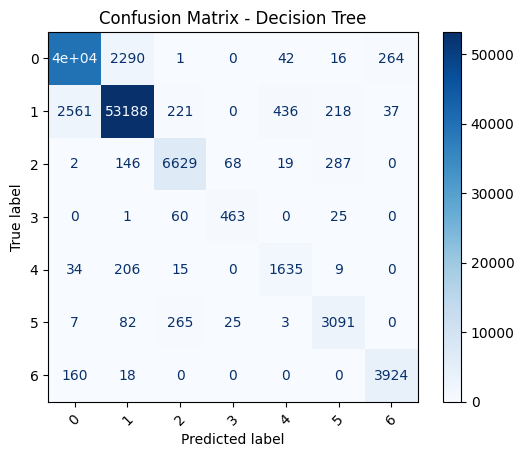

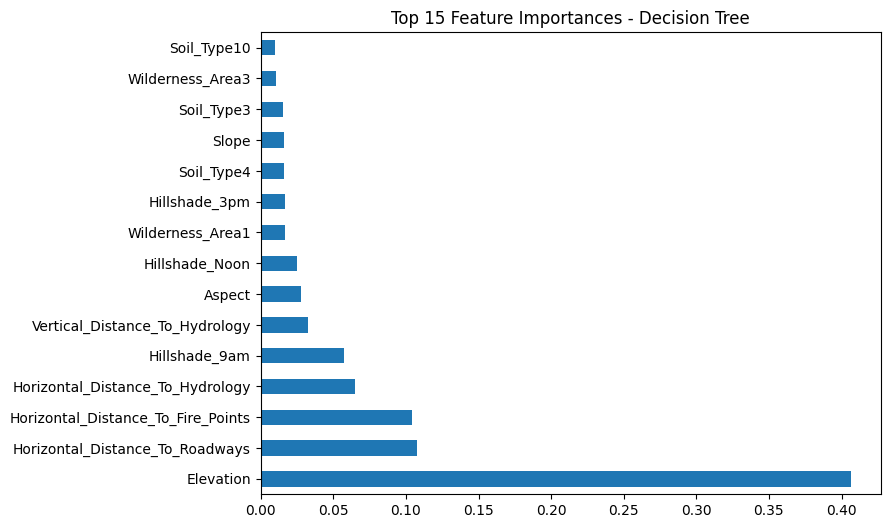


=== Random Forest ===
              precision    recall  f1-score   support

           0      0.964     0.949     0.956     42368
           1      0.962     0.964     0.963     56661
           2      0.938     0.960     0.949      7151
           3      0.867     0.900     0.883       549
           4      0.873     0.924     0.898      1899
           5      0.895     0.929     0.912      3473
           6      0.952     0.976     0.964      4102

    accuracy                          0.957    116203
   macro avg      0.922     0.943     0.932    116203
weighted avg      0.957     0.957     0.957    116203



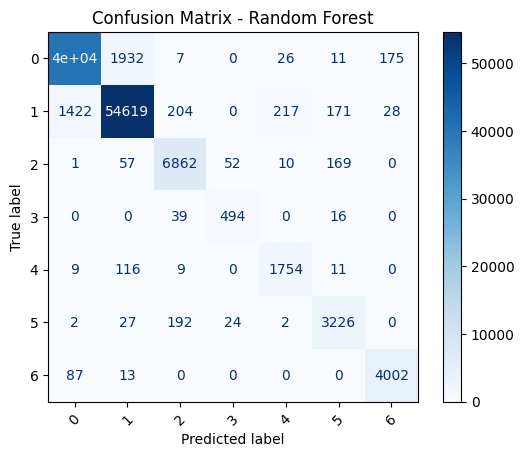

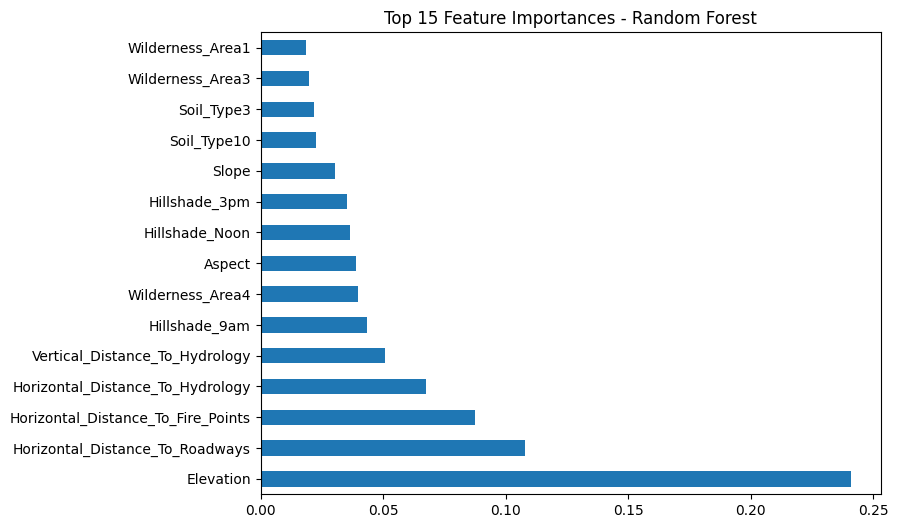


=== XGBoost ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:46:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0      0.825     0.835     0.830     42368
           1      0.884     0.804     0.842     56661
           2      0.861     0.894     0.877      7151
           3      0.768     0.942     0.846       549
           4      0.437     0.924     0.593      1899
           5      0.690     0.919     0.788      3473
           6      0.804     0.982     0.884      4102

    accuracy                          0.833    116203
   macro avg      0.753     0.900     0.809    116203
weighted avg      0.844     0.833     0.836    116203



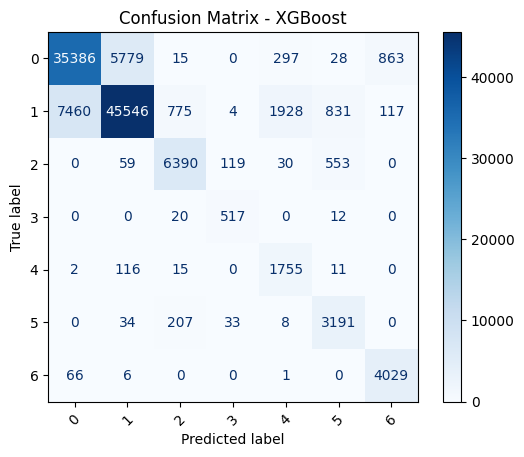

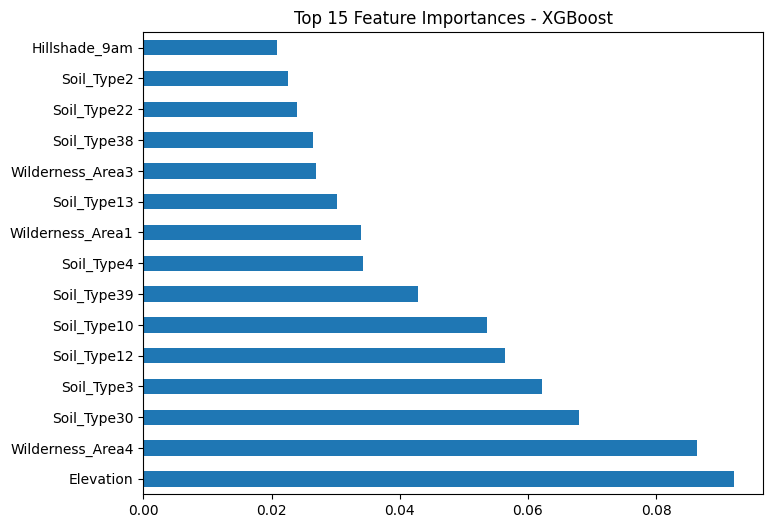

In [16]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        feat_imp = pd.Series(importances, index=data.columns[:-1])
        feat_imp.nlargest(15).plot(kind="barh", figsize=(8,6))
        plt.title(f"Top 15 Feature Importances - {name}")
        plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.680     0.664     0.672     42368
           1      0.790     0.520     0.627     56661
           2      0.697     0.564     0.623      7151
           3      0.293     0.883     0.440       549
           4      0.104     0.779     0.183      1899
           5      0.340     0.663     0.449      3473
           6      0.404     0.890     0.556      4102

    accuracy                          0.598    116203
   macro avg      0.472     0.709     0.507    116203
weighted avg      0.703     0.598     0.627    116203



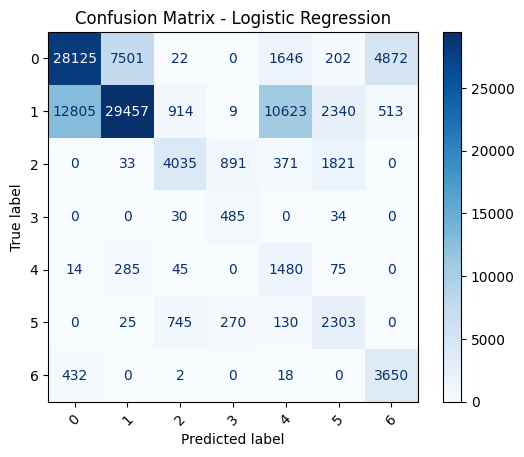

In [17]:
log_model = LogisticRegression(max_iter=200, multi_class="multinomial")
log_model.fit(X_train_res, y_train_res)
y_pred_log = log_model.predict(X_test)

print("\n=== Logistic Regression ===")
print(classification_report(y_test, y_pred_log, digits=3))
cm = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()
